# Triangular lattice barrier

**authors:** Joseph Marcus
 
Here I simulate genetic data under the coalescent in a triangular lattice with a barrier and explore the fit of different ways to compute expected genetic distances on simulated genotypes.

Lets load the necessary packages and modules to get started 

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../code/")
from habitat import *
from genotype_simulator import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Plot size configuration

In [3]:
sns.set_style('white')
plt.style.use('bmh')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

## Setup the habitat

Here we define a triangular lattice with 8 rows and 8 columns so we have 64 demes in total

In [4]:
hab = TriangularLattice(8, 8)

Next we need to define a migration surface which is a function on the nodes of the graph that define edge weights. Here I choose a quadratic function to match the simulations in the EEMS paper

In [6]:
def quad_barrier_migration(self, m_min, m_max):
    """
    Arguments:
        g : nx graph
            regular lattice
        s : array
            d x 2 array of spatial positions
            
    Returns:
        g: nx.graph
            regular lattice with assigned weights
    """
    s0_max = np.max(self.s[:,0])
    s0_med = np.median(self.s[:,0]) + .25
    for i,j in self.g.edges():
        mu = np.mean([self.s[i,0], self.s[j,0]])
        m = (s0_max / s0_med ** 2) * (mu - s0_med) ** 2 + m_min
        self.g[i][j]["m"] = min(m, m_max)
        
    self.m = nx.adjacency_matrix(self.g, weight='m')
    self.m = self.m.toarray()

We then assign this method to the habitat object

In [7]:
hab.migration_surface = quad_barrier_migration
hab.migration_surface(hab, .01, 3.)
# compute graph laplacian
hab.get_graph_lapl()

Lets visualize triangular lattice with edge widths proportional to the defined edge weights, note we multiply the weights by some constant just for visualization purposes. Additional the nodes have a color scheme based on their position on the map, particularly the x position difference is emphasized more than the y. the habitat

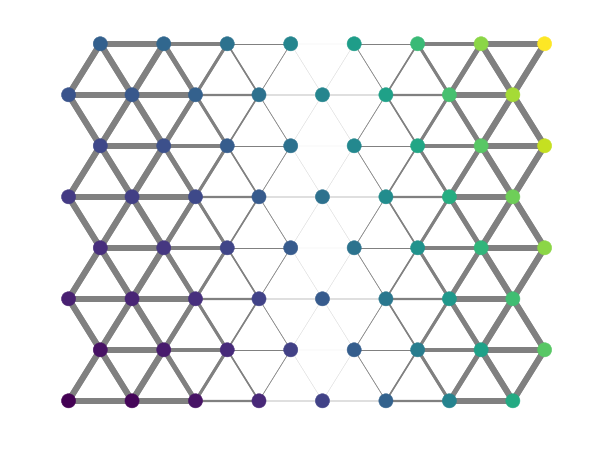

In [8]:
hab.plot_habitat(200, 2, False)

As expected we see that the migration matrix $\mathbf{M}$ is extremely sparse as only neighboring nodes are connected

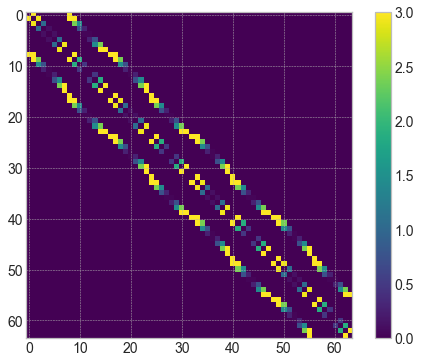

In [9]:
hab.plot_migration_matrix()

## Simulate genotypes

Here we simulate genotypes under the coalescent using msprime ... this may take a bit of time. Specifically we simulate 10 haploid individuals per deme in 5000 independent regions of the genome. See `../code/genotype_simulator.py` for default params and implementation of the simulation object.

In [12]:
sim_path = path = "../output/simulations/trilat_bar.pkl"
geno = GenotypeSimulator(hab, sim_path, n_rep=5e3)
print(geno.y.shape)

(640, 10349)


Here we visualize the site frequency spectrum which seems to match the neutral expectation

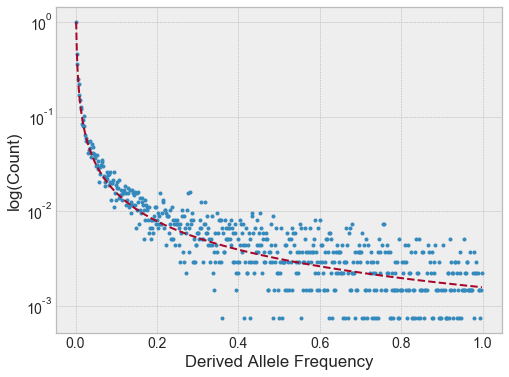

In [13]:
geno.plot_sfs()

Lets filter out too rare variants leavings us with fewer SNPs

In [14]:
geno.filter_rare_var()
print(geno.y.shape)

(640, 4666)


Lets peform PCA on the genotype matrix and visualize the first two PCs. Note that I center and scale the data matrix before running PCA.

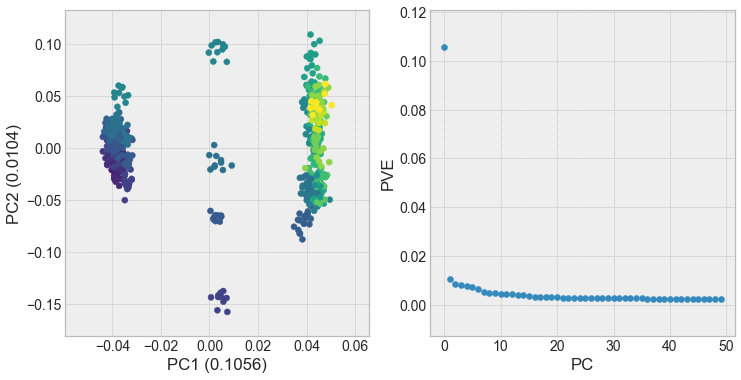

In [15]:
geno.pca()
geno.plot_pca(geno.pcs, geno.pves)

We see a strong signature of the barrier with two clusters based on geographic position on the x axis

## Expected genetic distances

We can see the graph laplacian is sparse as $\mathbf{M}$ is sparse. We can think of $\mathbf{L}$ here as a sparse precision matrix

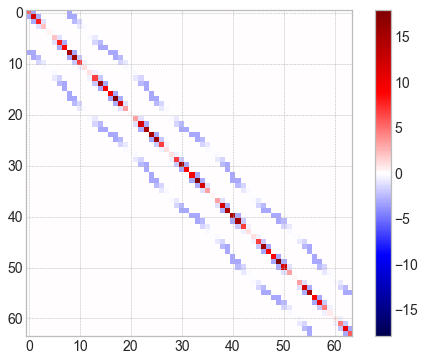

In [16]:
hab.plot_precision_matrix(hab.l)

We can see that $\mathbf{L}\mathbf{L}^T$ is also sparse but not as sparse. It seems to have an additional off-diagonal band

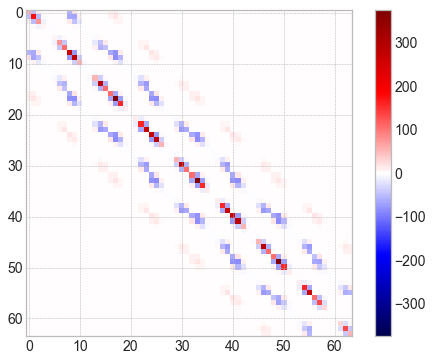

In [17]:
hab.plot_precision_matrix(hab.l @ hab.l.T)

Compute observed genetic distances and different models to compute expected genetic distances. Note that I center the data matrix before computing genetic distances but I do not scale.

In [18]:
# lower triangular indicies
tril_idx = np.tril_indices(geno.n, -1)

# observed genetic distance
d_geno = geno.geno_dist()
d_geno_tril = d_geno[tril_idx]

# geographic distance
d_geo = geno.node_to_obs_mat(hab.geo_dist(), geno.n, geno.v)
d_geo_tril = d_geo[tril_idx]

# resistence distance
d_res = geno.node_to_obs_mat(hab.rw_dist(hab.l), geno.n, geno.v)
d_res_tril = d_res[tril_idx]

# random-walk distance
d_rw = geno.node_to_obs_mat(hab.rw_dist(hab.l @ hab.l.T), geno.n, geno.v)
d_rw_tril = d_rw[tril_idx]

geo r2 = 0.5688471020706676


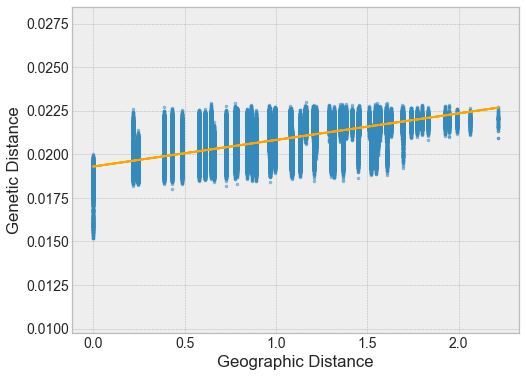

In [19]:
geno.plot_dist(d_geo_tril, d_geno_tril, "Geographic Distance", "Genetic Distance")

print('geo r2 = {}'.format(np.corrcoef(d_geo_tril, d_geno_tril)[0, 1]))

res r2 = 0.823326622560282


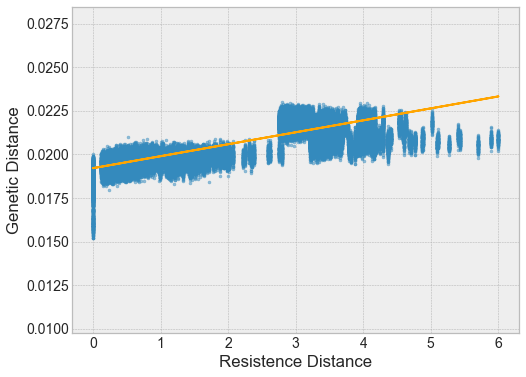

In [20]:
geno.plot_dist(d_res_tril, d_geno_tril, "Resistence Distance", "Genetic Distance")

print('res r2 = {}'.format(np.corrcoef(d_res_tril, d_geno_tril)[0, 1]))

rw r2 = 0.9437598919123633


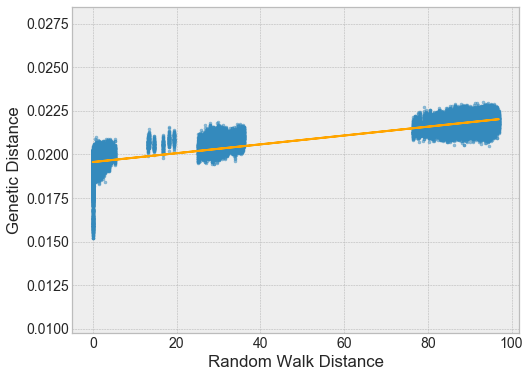

In [21]:
geno.plot_dist(d_rw_tril, d_geno_tril, "Random Walk Distance", "Genetic Distance")

print('rw r2 = {}'.format(np.corrcoef(d_rw_tril, d_geno_tril)[0, 1]))

In summary ...

In [22]:
print('geo r2 = {}'.format(np.corrcoef(d_geo_tril, d_geno_tril)[0, 1]))
print('res r2 = {}'.format(np.corrcoef(d_res_tril, d_geno_tril)[0, 1]))
print('rw r2 = {}'.format(np.corrcoef(d_rw_tril, d_geno_tril)[0, 1]))

geo r2 = 0.5688471020706676
res r2 = 0.823326622560282
rw r2 = 0.9437598919123633


We can see that the random-walk distance has the highest correlation with the genetic distance out of the 3 we compare here. It actually seems surprisingly high. Note that scale of the input distances would be different then the scale of genetic distance. We could add an additional variance parameter to scale the covariance matrix in the likelihood, which will be addressed when thinking about inference under this model. I don't have a good intuition for why the correlation would be higher for the "Random Walk Distance" even when simulating under a habitat with an undirected graph. One interesting feature of the "Random Walk Distance" semivariogram is that there seems to be 3 strong modes in the distance. This could make sense given the lattice structure and the simulated migration rates i.e. there are distances to compare across the barrier, within each region on either side of the barrier and within each deme?